In [1]:
'''always return latent vector and prediction'''
'''from py'''

'from py'

In [1]:
import util as u
pkl_folder="pkl"

train_set_name = "%s/train_data_no_aug.pkl"%pkl_folder
train_curve_label_name="%s/train_curve_label_no_aug.pkl"%pkl_folder
train_label_name= "%s/train_label_no_aug.pkl"%pkl_folder
train_dist_mat_name="%s/train_dist_mat_no_aug.pkl"%pkl_folder

test_set_name = "%s/test_data_no_aug.pkl"%pkl_folder
test_curve_label_name="%s/test_curve_label_no_aug.pkl"%pkl_folder
test_label_name= "%s/test_label_no_aug.pkl"%pkl_folder
test_dist_mat_name="%s/test_dist_mat_no_aug.pkl"%pkl_folder

train_set, train_curve_label, train_label, train_dist_mat,\
test_set, test_curve_label, test_label, test_dist_mat=\
u.load_dataset(train_set_name, train_curve_label_name, train_label_name, train_dist_mat_name,
             test_set_name, test_curve_label_name, test_label_name, test_dist_mat_name)

print(len(train_set))

18


In [2]:
#no augmentation, firsrt layer is average pool
model_path="phonesage_naug_norm.pt"

In [3]:
import random
import time
import math
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR,\
ExponentialLR, ReduceLROnPlateau 
import torch
import torch.nn as nn
from torch.optim import Adam

train_accuracy_path="%s/train_accuracy_naug_norm.pkl"%pkl_folder
train_loss_path="%s/train_loss_naug_norm.pkl"%pkl_folder
val_accuracy_path="%s/val_accuracy_naug_norm.pkl"%pkl_folder
val_loss_path="%s/val_loss_naug_norm.pkl"%pkl_folder

start=time.time()

train_loss_record=[]
train_accuracy_record=[]
val_loss_record=[]
val_accuracy_record=[]
val_min=1e9
loss_func=nn.BCELoss()
train_loss=0 #initialize

batch_size=5 #先假設可以整除
num_batches=int(len(train_label)/batch_size)
model = u.phonesage_norm(batch_size=batch_size)
lr=0.001
optim = Adam(model.parameters(), lr=lr)
scheduler = StepLR(optim, step_size=10, gamma=0.9)

#因為create有按照順序，先打亂再batch
train_zip=list(zip(train_set,train_curve_label,train_dist_mat,train_label))
random.shuffle(train_zip)
train_set,train_curve_label,train_dist_mat,train_label=zip(*train_zip)

#first evaluatiom
model.eval()
#temporarily use test as my val
model.batch_size=len(test_label)
_, val_pred=model(test_set,test_curve_label,test_dist_mat)

val_loss=loss_func(val_pred,torch.FloatTensor(test_label))
val_loss_record.append(val_loss.item())
val_acc=u.binary_acc(val_pred, torch.FloatTensor(test_label))
val_accuracy_record.append(val_acc)
# print("ok")
for epoch in range(800):
    start_i=0
    model.train()
    model.batch_size=batch_size
    for iteration in range(num_batches):
        train_batch=train_set[start_i:start_i+batch_size]
        train_curve_label_batch=train_curve_label[start_i:start_i+batch_size]
        train_dist_batch=train_dist_mat[start_i:start_i+batch_size]
        train_label_batch=train_label[start_i:start_i+batch_size]
        truth=torch.FloatTensor(train_label_batch)
        
        _, pred=model(train_batch,train_curve_label_batch,train_dist_batch)
        train_loss=loss_func(pred,truth)
        acc=u.binary_acc(pred, truth)
        train_accuracy_record.append(acc)
        train_loss_record.append(train_loss.item())
        optim.zero_grad()
        train_loss.backward(retain_graph=True)
        optim.step()
        start_i+=batch_size
        
        u.dump_item(train_accuracy_record, train_accuracy_path)
        u.dump_item(train_loss_record, train_loss_path)
    
    model.eval()
    #temporarily use test as my val
    model.batch_size=len(test_label)
    _, val_pred=model(test_set,test_curve_label,test_dist_mat)
    val_loss=loss_func(val_pred,torch.FloatTensor(test_label))
    val_loss_record.append(val_loss.item())
    val_acc=u.binary_acc(val_pred, torch.FloatTensor(test_label))
    val_accuracy_record.append(val_acc)
    
    u.dump_item(val_accuracy_record, val_accuracy_path)
    u.dump_item(val_loss_record, val_loss_path)
    
    if len(val_loss_record)>10:
        if val_loss<val_min:
            #save the model
            torch.save(model.state_dict(), model_path)
            val_min=val_loss
   
    if epoch%2==0:
        #shuffle train set to get different batches, but maybe not every time
        train_zip=list(zip(train_set,train_curve_label,train_dist_mat,train_label))
        random.shuffle(train_zip)
        train_set,train_curve_label,train_dist_mat,train_label=zip(*train_zip)
#         train_accuracy_record.append(acc)
#         train_loss_record.append(loss.item())
#         val_loss_record.append(val_loss.item())
#         val_accuracy_record.append(val_acc)
        print("epoch",epoch,"train loss",round(train_loss.item(),2),\
              "val loss",round(val_loss.item(),2),"time:",\
              u.timeSince(start))
    scheduler.step()

epoch 0 train loss 0.61 val loss 0.71 time: 0m 0s
epoch 2 train loss 0.68 val loss 0.7 time: 0m 0s
epoch 4 train loss 0.57 val loss 0.69 time: 0m 0s
epoch 6 train loss 0.52 val loss 0.67 time: 0m 0s
epoch 8 train loss 0.49 val loss 0.66 time: 0m 0s
epoch 10 train loss 0.45 val loss 0.63 time: 0m 0s
epoch 12 train loss 0.45 val loss 0.6 time: 0m 0s
epoch 14 train loss 0.59 val loss 0.54 time: 0m 0s
epoch 16 train loss 0.36 val loss 0.49 time: 0m 0s
epoch 18 train loss 0.23 val loss 0.44 time: 0m 0s
epoch 20 train loss 0.24 val loss 0.38 time: 0m 0s
epoch 22 train loss 0.38 val loss 0.33 time: 0m 0s
epoch 24 train loss 0.17 val loss 0.29 time: 0m 0s
epoch 26 train loss 0.17 val loss 0.16 time: 0m 0s
epoch 28 train loss 0.24 val loss 0.1 time: 0m 0s
epoch 30 train loss 0.07 val loss 0.09 time: 0m 0s
epoch 32 train loss 0.21 val loss 0.07 time: 0m 0s
epoch 34 train loss 0.07 val loss 0.06 time: 0m 0s
epoch 36 train loss 0.07 val loss 0.06 time: 0m 1s
epoch 38 train loss 0.05 val loss 0.09 

In [ ]:
# train_accuracy_path="%s/train_accuracy_naug_avg.pkl"%pkl_folder
# train_loss_path="%s/train_loss_naug_avg.pkl"%pkl_folder
# val_accuracy_path="%s/val_accuracy_naug_avg.pkl"%pkl_folder
# val_loss_path="%s/val_loss_naug_avg.pkl"%pkl_folder
# u.dump_item(train_accuracy_record, train_accuracy_path)
# u.dump_item(train_loss_record, train_loss_path)
# u.dump_item(val_accuracy_record, val_accuracy_path)
# u.dump_item(val_loss_record, val_loss_path)

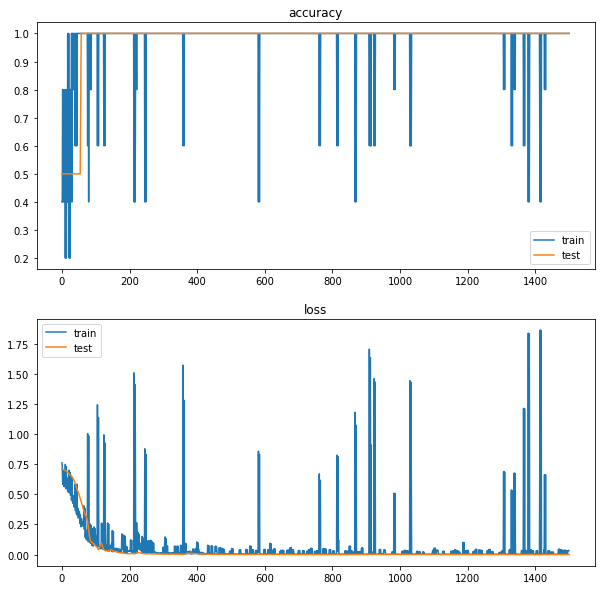

In [6]:
import matplotlib.pyplot as plt
plot_epochs=500
train_rec_end=plot_epochs * num_batches
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(train_accuracy_record[:train_rec_end],label="train")
x_axis = [*range(0, num_batches*(1+plot_epochs), num_batches)]
# plt.plot(x_axis, val_accuracy_record)
plt.plot(x_axis, val_accuracy_record[:plot_epochs+1],label="test")
plt.title("accuracy")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_loss_record[:train_rec_end],label="train")
plt.plot(x_axis, val_loss_record[:plot_epochs+1],label="test")
plt.title("loss")
plt.legend()

plt.show()